In [1]:
from ase_interface import ANIENS
from ase_interface import ensemblemolecule

import aniensemblestats as aes
import pyaniasetools as aat

import pyanitools as pyt

import numpy as np
import ase

#from ase.neb import NEBtools
from ase.io import read, write

import matplotlib
import matplotlib as mpl
from matplotlib import gridspec 
import matplotlib.pyplot as plt

import hdnntools as hdt

from scipy import stats

import os
os.environ["OMP_NUM_THREADS"] = "8"

import  ase
from ase.md.langevin import Langevin
from ase.md.verlet import VelocityVerlet
from ase.io.trajectory import Trajectory
from ase import units

from ase.optimize.fire import FIRE as QuasiNewton
from ase.optimize import LBFGS

from ase.md.nvtberendsen import NVTBerendsen
from ase.md import MDLogger

from ase.io import read, write

from ase.parallel import world

import time

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## DFT -> CCSD Transfer learned
ntdir = '/home/jsmith48/scratch/CCSD_Water_train/model3/'
cns = ntdir + 'rHO-6.0R_32-3.5A_a4-8.params'
sae = ntdir + 'sae_linfit.dat'
nnf = ntdir + 'train'
Nn = 8

water = '/home/jsmith48/scratch/CCSD_Water_train/water.pdb'

GPU = 0

In [3]:
mol = read(water)

# Set NC
aens = ensemblemolecule(cns, sae, nnf, Nn, GPU)

# Set ANI calculator
mol.set_calculator(ANIENS(aens))

# Optimize molecule
start_time = time.time()
dyn = LBFGS(mol)
dyn.run(fmax=0.0001,steps=3000)
print('[ANI Total time:', time.time() - start_time, 'seconds]')

Ewat = mol.get_potential_energy()*hdt.evtokcal
print(Ewat)

       Step     Time          Energy         fmax
LBFGS:    0 12:33:12    -2078.391745        2.1272
LBFGS:    1 12:33:12    -2078.477743        0.6137
LBFGS:    2 12:33:12    -2078.489234        0.4919
LBFGS:    3 12:33:12    -2078.504678        0.0834
LBFGS:    4 12:33:12    -2078.504755        0.0247
LBFGS:    5 12:33:12    -2078.504759        0.0068
LBFGS:    6 12:33:12    -2078.504760        0.0008
LBFGS:    7 12:33:12    -2078.504760        0.0001
[ANI Total time: 0.06524109840393066 seconds]
-47931.44620274689


In [4]:
ts = '/home/jsmith48/scratch/CCSD_Water_train/CCSD-wat-15to25-partial.h5'

In [5]:
# Set NC
aens = aat.anicrossvalidationconformer(cns, sae, nnf, Nn, [GPU])

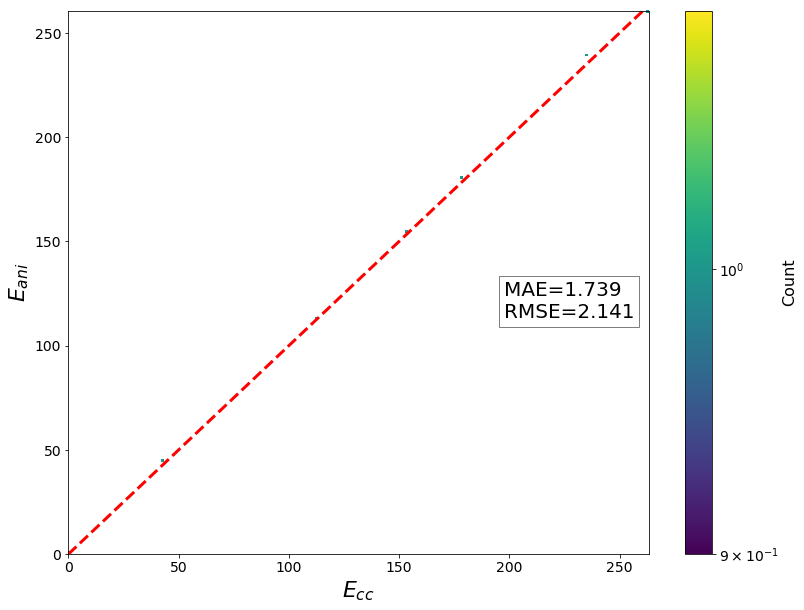

Computing: 0 57 /1310 Nm: 8 Na: 57 Err: 1.8565442683757283


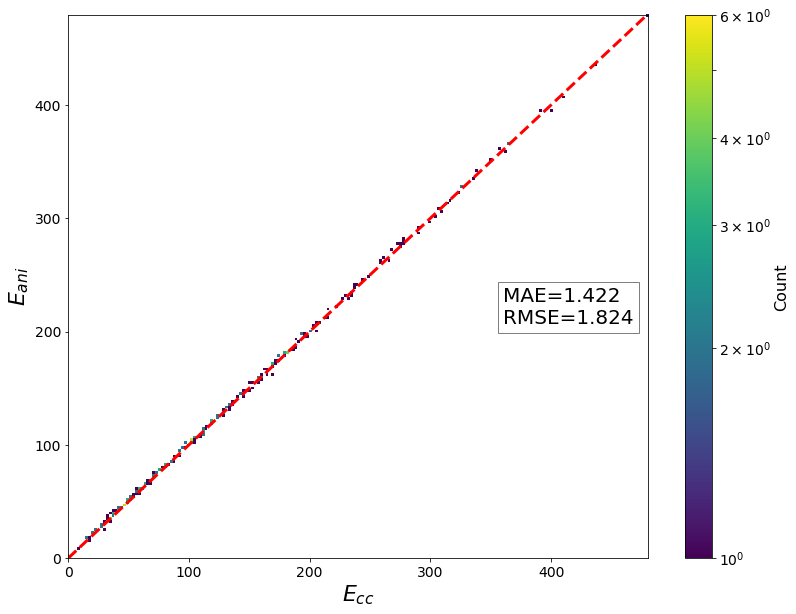

Computing: 1 48 /238 Nm: 302 Na: 48 Err: 1.335966370911538


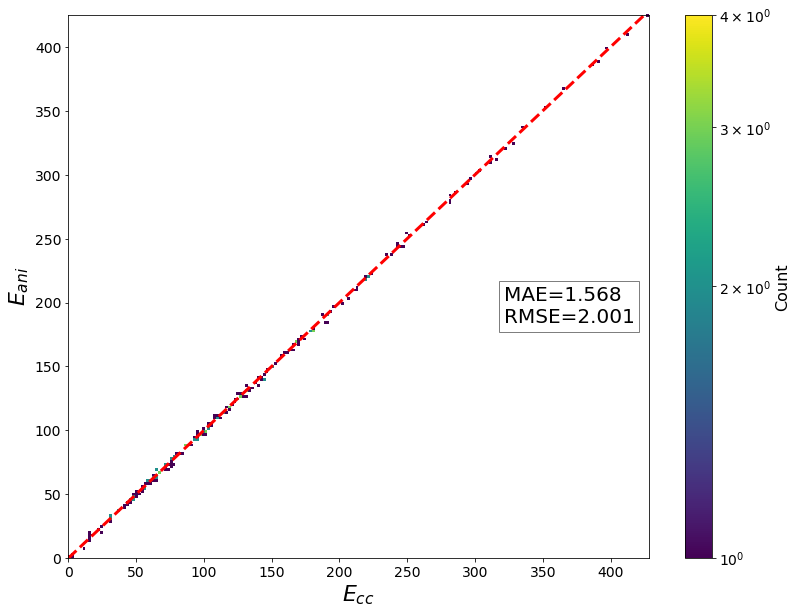

Computing: 2 54 /2968 Nm: 231 Na: 54 Err: 1.462724725674491


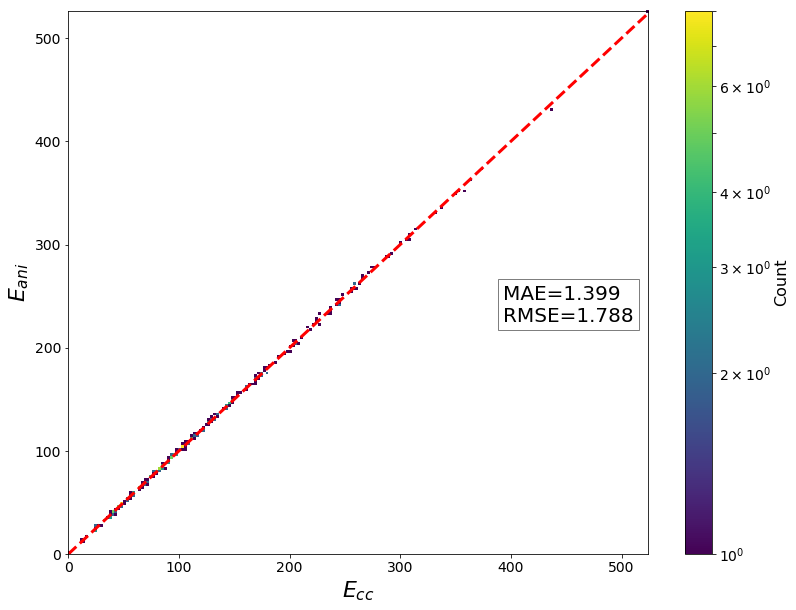

Computing: 3 51 /3265 Nm: 289 Na: 51 Err: 1.3888229962879837


In [6]:
Eal=[]
Eat=[]
dEal=[]
Emin=[]

Fan=[]
Fmp1=[]
Fmp2=[]

Na = []
adl = pyt.anidataloader(ts)
for i,data in enumerate(adl):
    # Get reference data
    X = np.array(data['coordinates'],dtype=np.float32)
    S = data['species']

    E = hdt.hatokcal*data['energies']
    F1 = -hdt.hatokcal*data['mp2_dz_grad']*1.8897259886
    Fmp1.append(F1.flatten())
    F2 = -hdt.hatokcal*data['mp2_tz_grad']*1.8897259886
    Fmp2.append(F2.flatten())
    #Na.append(len(S))

    # Define Eref
    Eref = E

    # Compute energies and forces
    Ea1_t,Fa1_t,Sa1 = aens.compute_energyandforce_conformations(X,S)
    Fan.append(Fa1_t.flatten())

    aes.plot_corr_dist((Eref-len(S)*Ewat)-(Eref-len(S)*Ewat).min(),(Ea1_t-len(S)*Ewat)-(Ea1_t-len(S)*Ewat).min(),xlabel=r'$E_{cc}$',ylabel=r'$E_{ani}$', inset=False)
    
    print('Computing:',i,len(S),data['path'],'Nm:',E.size,'Na:',len(S),'Err:',hdt.calculatemeanabserror(Eref,Ea1_t))

    Esae = hdt.hatokcal*hdt.compute_sae(sae, S)

    # Define NN shifted energies
    Eal1 = Ea1_t # TL

    # Define NN E distmats
    dEal1 = hdt.calculatedmat(Ea1_t)

    # Store E mins
    Emin.append(np.array([[Eref.min(),Eal1.min()]]))

    # Store E and dE
    Eal.append(np.vstack([Eref,Eal1,Sa1]))
    Eat.append(np.vstack([(Eref-Esae)/(len(S)/3),(Eal1-Esae)/(len(S)/3)]))
    dEal.append(np.vstack([hdt.calculatedmat(Eref),dEal1]))
    #print(dEal[-1].shape)
        
Eal = np.hstack(Eal)
Eat = np.hstack(Eat)
dEal = np.hstack(dEal)
#print(dEal.shape,dEal)
Na = np.array(Na)
Emin=np.vstack(Emin)

Fmp1 = np.concatenate(Fmp1)
Fmp2 = np.concatenate(Fmp2)
Fan = np.concatenate(Fan)

In [7]:
print(hdt.calculatemeanabserror(Eal[0,:],Eal[1,:]))
print(hdt.calculaterootmeansqrerror(Eal[0,:],Eal[1,:]))

1.3946668141208736
1.78912310663951


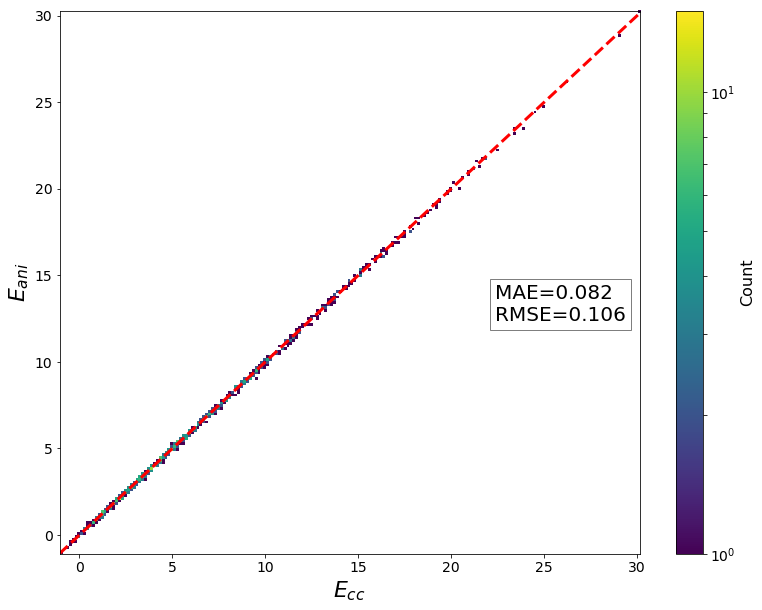

In [8]:
aes.plot_corr_dist(Eat[0,:],Eat[1,:],xlabel=r'$E_{cc}$',ylabel=r'$E_{ani}$', inset=False)

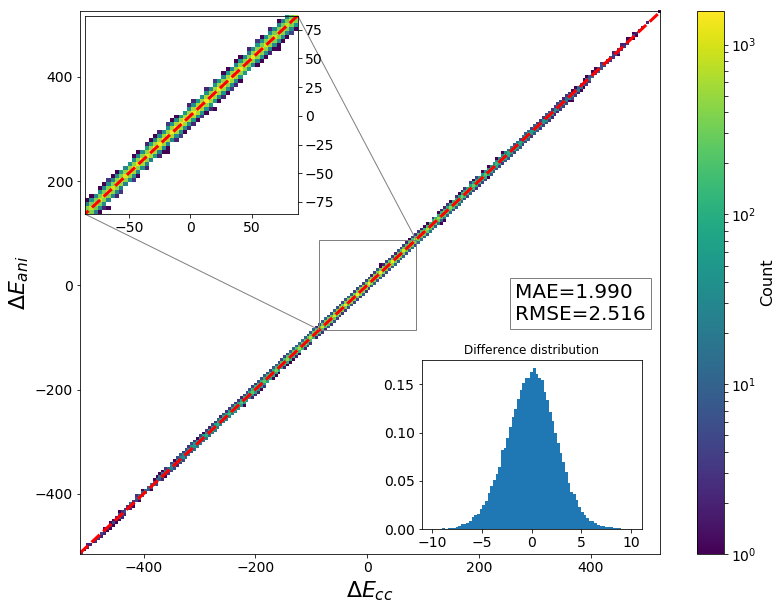

In [9]:
aes.plot_corr_dist(dEal[0,:],dEal[1,:],xlabel=r'$\Delta$$E_{cc}$',ylabel=r'$\Delta$$E_{ani}$')

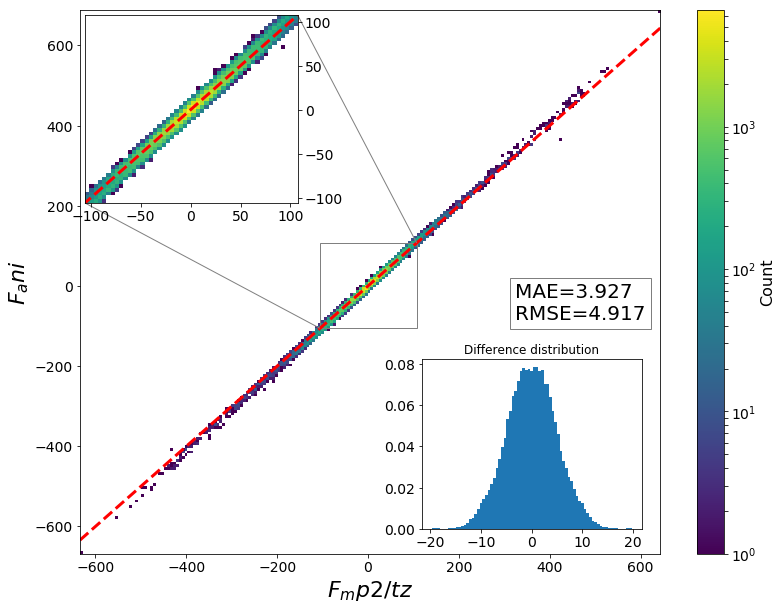

In [11]:
aes.plot_corr_dist(Fmp2,Fmp1,xlabel=r'$F_mp2/tz$',ylabel=r'$F_ani$')